### Install and import libraries

In [1]:
# If needed, install libraries (run once in your environment)
# !pip install lifelines scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import CoxPHFitter

from sklearn.model_selection import KFold
from lifelines.utils import k_fold_cross_validation


### Load dataset

In [2]:
# Load the Telco Customer Churn dataset from the project folder
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


###  Quick data overview

In [3]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Shape: (7043, 21)

Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecur

### Basic cleaning: handle TotalCharges as numeric and drop missing

In [4]:
# TotalCharges sometimes comes as object; coerce to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing TotalCharges after coercion
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

print("Shape after dropping rows with missing TotalCharges:", df.shape)


Shape after dropping rows with missing TotalCharges: (7032, 21)


### Define survival variables (time and event)

In [5]:
# time: tenure (months)
time_col = "tenure"

# event: churn (Yes=1, No=0)
df["Churn_event"] = df["Churn"].map({"Yes": 1, "No": 0})

df[["tenure", "Churn", "Churn_event"]].head()


,tenure,Churn,Churn_event
0,1,No,0
1,34,No,0
2,2,Yes,1
3,45,No,0
4,2,Yes,1


### Basic exploratory plots of main variables

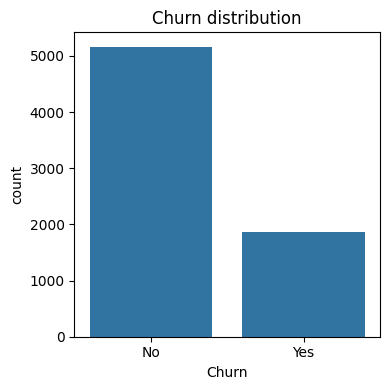

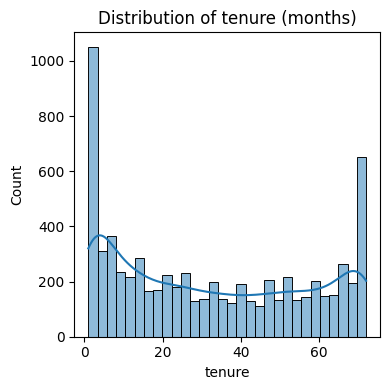

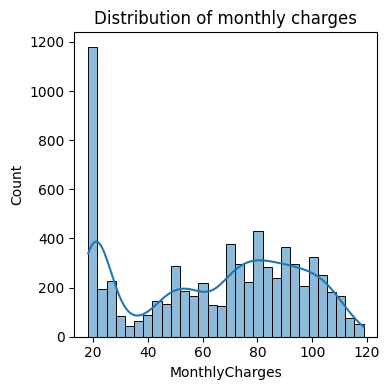

In [7]:
# 1) Churn distribution
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x="Churn")
plt.title("Churn distribution")
plt.tight_layout()
plt.savefig("churn_distribution.png", dpi=300)   # saved as a separate file
plt.show()

# 2) Tenure distribution
plt.figure(figsize=(4, 4))
sns.histplot(df["tenure"], bins=30, kde=True)
plt.title("Distribution of tenure (months)")
plt.tight_layout()
plt.savefig("tenure_distribution.png", dpi=300)
plt.show()

# 3) Monthly charges distribution
plt.figure(figsize=(4, 4))
sns.histplot(df["MonthlyCharges"], bins=30, kde=True)
plt.title("Distribution of monthly charges")
plt.tight_layout()
plt.savefig("monthly_charges_distribution.png", dpi=300)
plt.show()


### Kaplan–Meier curves by Contract type

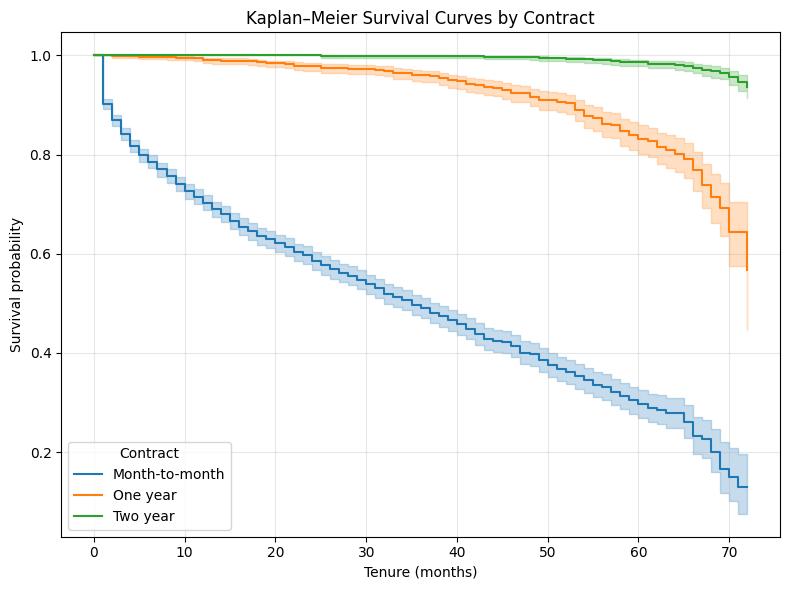

In [12]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for name, grouped_df in df.groupby("Contract"):
    kmf.fit(
        durations=grouped_df[time_col],
        event_observed=grouped_df["Churn_event"],
        label=name
    )
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Survival Curves by Contract")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival probability")
plt.legend(title="Contract")
plt.grid(True, alpha=0.3)

# Save figure (choose your name and format)
plt.tight_layout()
plt.savefig("km_survival_by_contract.png", dpi=300)  # or .pdf, .svg, etc.

plt.show()


###  Global log-rank test for Contract groups

In [9]:
# Global log-rank test comparing survival across all contract types
results_contract = multivariate_logrank_test(
    event_durations=df[time_col],
    groups=df["Contract"],
    event_observed=df["Churn_event"]
)

print("Global log-rank test for Contract:")
print(results_contract.summary)


Global log-rank test for Contract:
   test_statistic    p  -log2(p)
0     2352.872538  0.0       inf


### Pairwise log-rank tests for Contract groups

In [10]:
contract_types = df["Contract"].unique()
pairwise_results = []

for i in range(len(contract_types)):
    for j in range(i + 1, len(contract_types)):
        g1 = contract_types[i]
        g2 = contract_types[j]
        df1 = df[df["Contract"] == g1]
        df2 = df[df["Contract"] == g2]
        
        res = logrank_test(
            df1[time_col], df2[time_col],
            event_observed_A=df1["Churn_event"],
            event_observed_B=df2["Churn_event"]
        )
        pairwise_results.append({
            "Group 1": g1,
            "Group 2": g2,
            "Test statistic": res.test_statistic,
            "p-value": res.p_value
        })

pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df


,Group 1,Group 2,Test statistic,p-value
0,Month-to-month,One year,926.064559,2.117327e-203
1,Month-to-month,Two year,1550.510307,0.000000e+00
2,One year,Two year,256.217767,1.145448e-57


### Kaplan–Meier curves by PaymentMethod

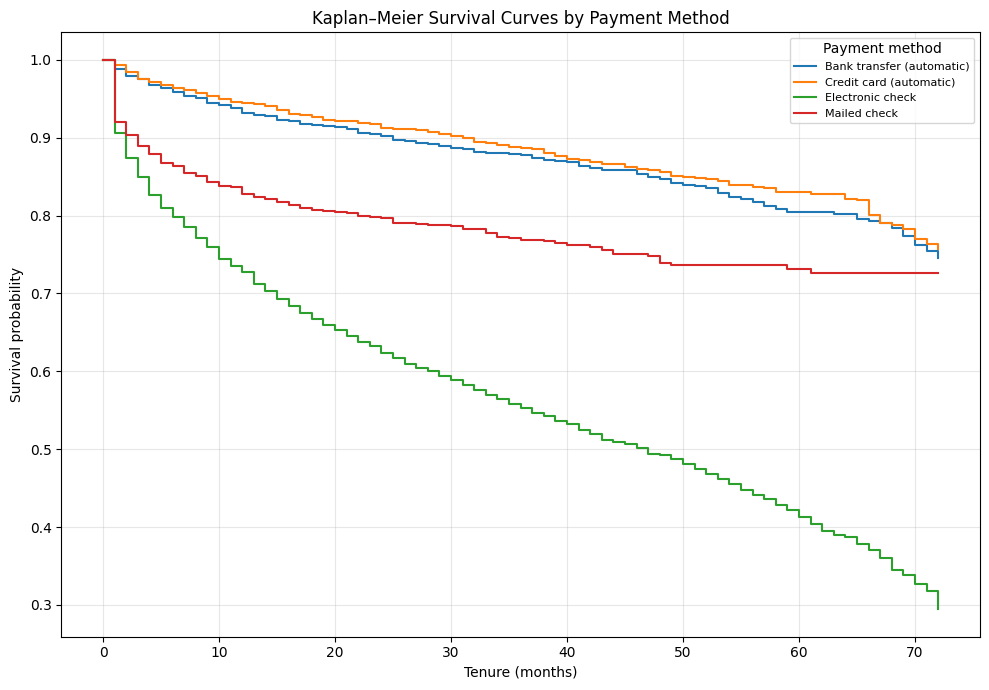

In [13]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))

for name, grouped_df in df.groupby("PaymentMethod"):
    kmf.fit(
        durations=grouped_df[time_col],
        event_observed=grouped_df["Churn_event"],
        label=name
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves by Payment Method")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival probability")
plt.legend(title="Payment method", fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("km_survival_by_payment_method.png", dpi=300)  # choose name/format

plt.show()


### Select variables for Cox models

In [14]:
# Choose covariates: demographics + services + account info
categorical_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# One-hot encode categorical variables (drop first to avoid collinearity)
df_encoded = pd.get_dummies(df,
                            columns=categorical_cols,
                            drop_first=True)

df_encoded.head()


,customerID,tenure,MonthlyCharges,TotalCharges,Churn,Churn_event,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,No,0,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,5575-GNVDE,34,56.95,1889.50,No,0,True,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,3668-QPYBK,2,53.85,108.15,Yes,1,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,7795-CFOCW,45,42.30,1840.75,No,0,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,9237-HQITU,2,70.70,151.65,Yes,1,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


### Define data for Cox model and standardize numeric covariates (except time)

In [15]:
# Keep survival columns and encoded covariates
cols_to_use = [time_col, "Churn_event"] + [c for c in df_encoded.columns
                                           if c not in [time_col, "Churn", "Churn_event", "customerID"]]

cox_df = df_encoded[cols_to_use].copy()

# Standardize selected numeric covariates (not the time column)
for col in ["MonthlyCharges", "TotalCharges"]:
    mean = cox_df[col].mean()
    std = cox_df[col].std()
    cox_df[col] = (cox_df[col] - mean) / std

cox_df.head()


,tenure,Churn_event,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,-1.161611,-0.994123,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,0,-0.260859,-0.173727,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,1,-0.363897,-0.959581,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,0,-0.747797,-0.195234,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,1,0.196164,-0.940391,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


### Fit standard Cox proportional hazards model

In [17]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(cox_df, duration_col=time_col, event_col="Churn_event")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -13045.80
         time fit was run = 2026-02-07 11:45:35 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                         0.24      1.27      0.10            0.03            0.44                1.03                1.56
TotalCharges                          -2.41      0.09      0.06           -2.54           -2.29                0.08                0.10
gender_Male                           -0.04      0.96      0.05           -0.13            0.05                0.88                1.05
SeniorCitizen_1                        0.02      1.02      0.06           -0.09            0.13                0.92                1.14
Partner_Yes                           -0.24      0.79      0.05           -0.34           -0.13                0.71                0.88
Dependents_Yes                        -0.11      0.90      0.07           -0.24            0.02                0.79                1.02
PhoneService_Yes                       0.26      1.30      0.29           -0.31            0.84                0.73                2.31
MultipleLines_No phone service        -0.26      0.77      0.29           -0.84            0.31                0.43                1.36
MultipleLines_Yes                     -0.02      0.98      0.05           -0.12            0.09                0.89                1.09
InternetService_Fiber optic            0.85      2.35      0.11            0.64            1.06                1.91                2.89
InternetService_No                    -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
OnlineSecurity_No internet service    -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
OnlineSecurity_Yes                    -0.32      0.72      0.07           -0.46           -0.19                0.63                0.82
OnlineBackup_No internet service      -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
OnlineBackup_Yes                      -0.16      0.85      0.06           -0.27           -0.05                0.77                0.95
DeviceProtection_No internet service  -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
DeviceProtection_Yes                  -0.00      1.00      0.06           -0.11            0.11                0.89                1.11
TechSupport_No internet service       -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
TechSupport_Yes                       -0.19      0.83      0.07           -0.32           -0.06                0.73                0.94
StreamingTV_No internet service       -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
StreamingTV_Yes                        0.21      1.24      0.06            0.09            0.33                1.09                1.39
StreamingMovies_No internet service   -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
StreamingMovies_Yes                    0.20      1.22      0.06            0.08            0.32                1.08                1.38
Contract_One year                     -1.04      0.35      0.09           -1.21           -0.87                0.30                0.42
Contract_Two year           

### Visualise hazard ratios (forest plot)

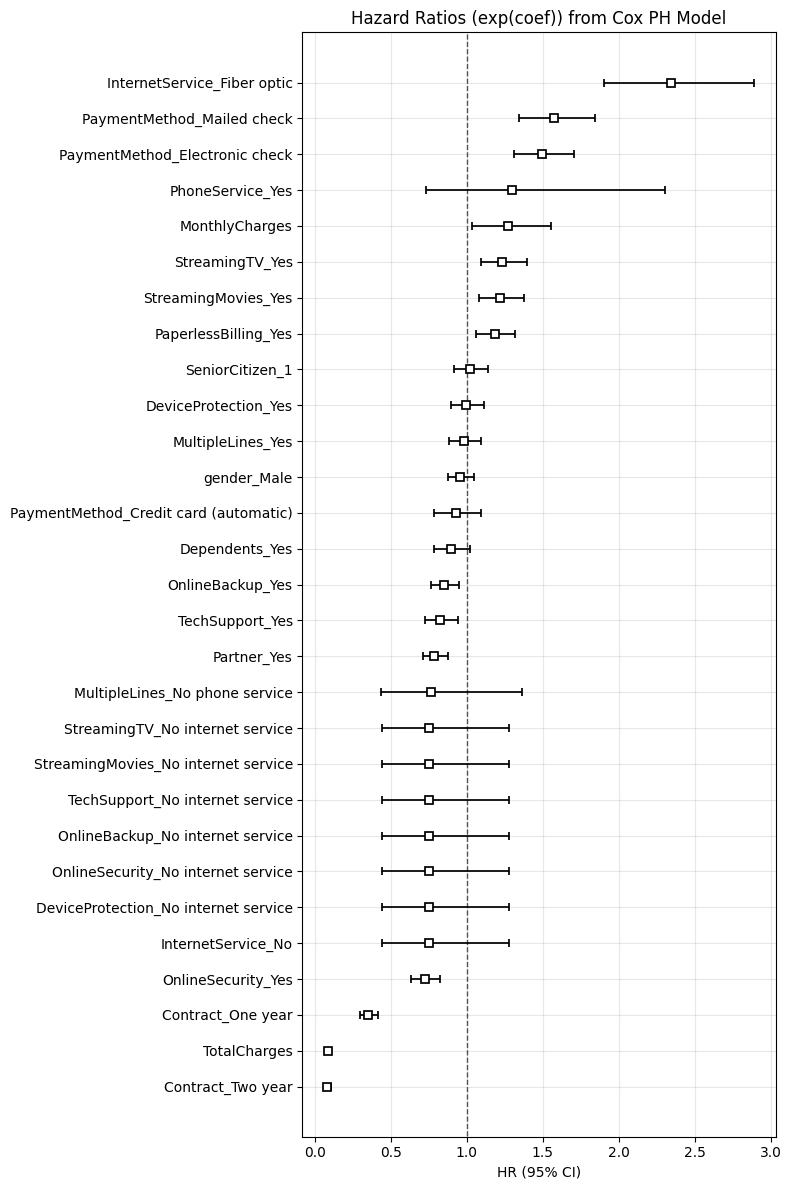

In [20]:
plt.figure(figsize=(8, 12))        # set figure size here
ax = cph.plot(hazard_ratios=True)  # no figsize argument

plt.title("Hazard Ratios (exp(coef)) from Cox PH Model")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure to a file
plt.savefig("cox_hazard_ratios.png", dpi=300)  # or .pdf / .svg etc.

plt.show()
